In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class RNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, vocab_size):
        super(RNN, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.rnn = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_out = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.layer_norm(embedded)

        output, _ = self.rnn(embedded)

        output = self.fc_out(output)
        
        return output[:,-1,:]
    
    def sample(self, seed, idx2word):

        self.eval()     
        with torch.no_grad():
            seed = self.embedding(seed)

            output, _ = self.rnn(seed)

            output = output[-1, :]

            logits = self.fc(output)

            prob = F.softmax(logits, dim=0)

            sample_ix = torch.multinomial(prob, 1, replacement=True).item()

            return idx2word[sample_ix]

In [16]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, vocab_size):
        super(LSTM, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.rnn = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_out = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.layer_norm(embedded)

        output, _ = self.rnn(embedded)

        output = self.fc_out(output)
        
        return output[:,-1,:]

In [17]:
class GRU(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, vocab_size):
        super(GRU, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.rnn = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_out = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.layer_norm(embedded)

        output, _ = self.rnn(embedded)

        output = self.fc_out(output)
        
        return output[:,-1,:]

In [2]:
def divide_text(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words))]

    return output_text

In [3]:
def custom_dataset(txt_file : str, sequence_length, step_size, embedding_dim, batch_size, training_fraction):
    ''' Function creating dataset
    
    Inputs
    ----------
    file1 : str, name of the file containing the first corpus
    file2 : str, name of the file containing the second corpus
    file3 : str, name of the file containing the third corpus
    sequence_length : int
    embedding_dim : int, number of dimension for the embedded words using Word2vec model
    batch_size : int
    training_fraction : float, fraction of training data
    
    
    Returns
    ----------
    dataloader_train : istance of torch.utils.data.Dataloader, training data
    dataloader_val : istance of torch.utils.data.Dataloader, validation data
    embedding_dim : int
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    word2vec : trained Word2vec model
    idx2word : dictionary from indices to words
    word2idx : dictionart from words to indices
    vocab_size : int, number of unique tokens
    style0_test : torch tensor containing every test data belonging to first style
    style1_test : torch tensor containing every test data belonging to second style
    style3_test : torch tensor containing every test data belonging to third style'''

    # reading the two corpus
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read()


    # divide the whole text to feed the Word2vec model
    divided_text = divide_text(text, sequence_length)

    # training the Word2vec model with the whole corpus
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = sequence_length, min_count=1, workers=4, epochs = 30)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    # creating the embedding matrix from the trained Word2vec model
    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


    text = text.split()
    encoded_text = [word2idx[char] for char in text]

    inputs = []
    targets = []

    text_len = len(text)
    for i in range(0, text_len - sequence_length, step_size):
        inputs.append(encoded_text[i: i + sequence_length])
        targets.append(encoded_text[i + sequence_length])
    

    train_inputs = inputs[: int(training_fraction*len(inputs))]
    train_targets = targets[: int(training_fraction*len(targets))]

    train_inputs = torch.LongTensor(train_inputs)
    train_targets = torch.LongTensor(train_targets)


    dataset_train = TensorDataset(train_inputs, train_targets)

    # Create a training DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
   


    val_inputs = inputs[int(training_fraction*len(inputs)) :]
    val_targets = targets[int(training_fraction*len(targets)) :]


    val_inputs = torch.LongTensor(val_inputs)
    val_targets = torch.LongTensor(val_targets)

    dataset_val = TensorDataset(val_inputs, val_targets)

    # Create a validation DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size

In [14]:
def loss_function(last_words, targets, loss_fn = nn.CrossEntropyLoss()):
    ''' Function computing loss function for classification
    
    Inputs
    ---------
    pred_labels : 3D torch tensor with predicted labels with shape [1, Batch size, 3]
    labels : 2D torch tensor with ground truth labels with shape [Batch size, 3]
    
    Returns
    ---------
    L : float, loss value '''

    L = loss_fn(last_words, targets)
    
    return L

In [12]:
def training(model, train_loader, val_loader, num_epochs, lr = 4e-4, title = 'Training'):
    ''' Training function
    
    Input
    --------
    model : istance of a CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier or TClassifier
    train_loader : istance of torch Dataloader with training data and labels
    val_loader : istance of torch Dataloader with validation data and labels
    num_epochs : int, number of epochs
    lr : float, learning rate for Adam optimizer
    title : str, Title of the matplot figure
    
    Returns
    --------
    train_losses : list with train loss values '''

    params = list(model.parameters())

    # Optimizer
    optimizer = torch.optim.Adam(params, lr = lr)

    train_losses = []
    val_losses = []

    # For loop over epochs
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0

        # For loop for every batch
        for  i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            targets = targets.type(torch.LongTensor)

            optimizer.zero_grad()
            

            # forward pass through classifier
            last_words = model(inputs)
            
            # comuting training loss
            loss = loss_function(last_words.to(device),
                                     targets.to(device))
            
            loss.backward()
            train_loss += loss.item()


            optimizer.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(inputs)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(inputs):.6f}')
        
        
        # Validation
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)

                targets = targets.type(torch.LongTensor)

                # forward pass through classifier
                last_words = model(inputs)
                
                
                # comuting validation loss
                val_loss_tot = loss_function(last_words.to(device),
                                     targets.to(device))
                
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(inputs)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(inputs):.6f}')
            
            
        # Computing average training and validation loss
        average_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        # printing average training and validation losses
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
    

    # Plotting training and validation curve at the end of the for loop 
    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

    return train_losses

In [ ]:
def inference(model, word2idx, seed_seq='nel mezzo del cammin di nostra vita', sample_len=50):
    """
    this function performs inference from the chosen model, generating text from a seed sequence
        Parameters:
            model: the chosen model
            seed_seq: the chosen sequence which the model has to continue with thext generation
            sample_len: the lenght of the sampled text
        Returns:
            the sampled text from the model
    """

    seed = [word2idx[word] for word in seed_seq.split()]
    for _ in range(sample_len):
        prediction = model.sample(seed)
        seed_seq.append(' ' + prediction)

    sampled_txt = ''.join(seed_seq)

    return sampled_txt

In [4]:
sequence_length = 20
step_size = 13
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [5]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size = custom_dataset('divina_commedia.txt',
                                                                                                                    sequence_length,
                                                                                                                    step_size,
                                                                                                                    embedding_dim,
                                                                                                                    batch_size,
                                                                                                                    0.9)

print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

total number of training samples:  7033
total number of validation samples:  782
vocab size:  12761


In [18]:
rnn = RNN(embedding_matrix, hidden_dim, 1, vocab_size)

In [19]:
model_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)

print('Total parameters: ', model_params)

Total parameters:  117929


 20%|██        | 1/5 [00:06<00:27,  6.82s/it]

====> Epoch: 1 Average train loss: 0.2975, Average val loss: 0.2993


 40%|████      | 2/5 [00:13<00:20,  6.93s/it]

====> Epoch: 2 Average train loss: 0.2820, Average val loss: 0.2837


 60%|██████    | 3/5 [00:21<00:14,  7.19s/it]

====> Epoch: 3 Average train loss: 0.2617, Average val loss: 0.2678


 80%|████████  | 4/5 [00:29<00:07,  7.52s/it]

====> Epoch: 4 Average train loss: 0.2442, Average val loss: 0.2570


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]

====> Epoch: 5 Average train loss: 0.2316, Average val loss: 0.2491


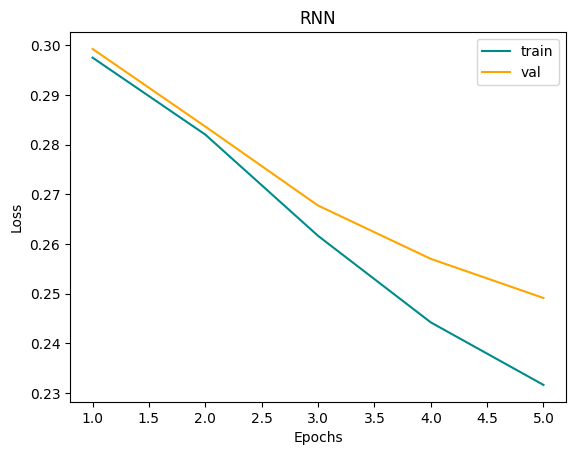

In [20]:
train_losses = training(rnn, train_loader, val_loader, 5, title = 'RNN')